<a href="https://colab.research.google.com/github/mpilomthiyane97/ai-engineering/blob/main/Visualizing_Token_Embeddings_and_Similarity_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tokenized: ['[CLS]', 'king', ',', 'queen', ',', 'man', ',', 'woman', '[SEP]']
Token IDs: [101, 2332, 1010, 3035, 1010, 2158, 1010, 2450, 102]
Embedding shape for 'king': (768,)
Embedding sample: [0.027000000700354576, 0.20399999618530273, 0.42899999022483826, -0.7070000171661377, -0.3889999985694885] ...
Embedding shape for 'queen': (768,)
Embedding sample: [0.8420000076293945, -0.26100000739097595, 0.1720000058412552, -0.781000018119812, -0.5419999957084656] ...
Cosine similarity between 'king' and 'queen': 0.67


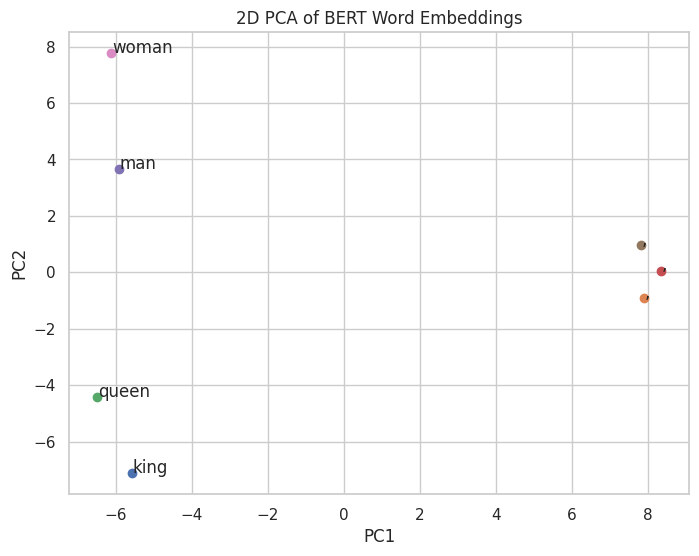

Cosine Similarity Matrix:


,king,",",queen,",",man,",",woman
king,1.00,0.42,0.67,0.39,0.56,0.37,0.40
",",0.42,1.00,0.44,0.95,0.38,0.88,0.37
queen,0.67,0.44,1.00,0.43,0.56,0.39,0.58
",",0.39,0.95,0.43,1.00,0.39,0.92,0.39
man,0.56,0.38,0.56,0.39,1.00,0.40,0.70
",",0.37,0.88,0.39,0.92,0.40,1.00,0.40
woman,0.40,0.37,0.58,0.39,0.70,0.40,1.00


In [ ]:

'''Tokenize text

Visualize token IDs and actual tokens

Get vector embeddings of tokens/words

Compute and visualize cosine similarity between word vectors'''

# Step 1: Install required libraries
!pip install transformers scikit-learn seaborn
!pip install huggingface_hub[hf_xet]
# Step 1: Install required libraries
# transformers - for pretrained LLMs like BERT
# scikit-learn - for cosine similarity and PCA
# seaborn - for pretty plots
!pip install transformers scikit-learn seaborn

# Step 2: Import required Python libraries
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Load the pretrained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Converts text into tokens/IDs
model = AutoModel.from_pretrained("bert-base-uncased")          # Provides the actual vector embeddings
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

# Step 4: Define your input sentence
text = "king, queen, man, woman"

# Tokenize the input: returns token IDs, attention masks, etc.
tokens = tokenizer(text, return_tensors="pt")

# Convert token IDs back to string tokens for human-readable output
token_strings = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

print(f"Tokenized: {token_strings}")
print(f"Token IDs: {tokens['input_ids'][0].tolist()}")

# Step 5: Get the output embeddings from the model
with torch.no_grad():  # Disable gradient tracking (saves memory)
    outputs = model(**tokens)
    # Get the last hidden layer embeddings (shape: [seq_len, hidden_dim])
    embeddings = outputs.last_hidden_state[0]

# Step 6: Filter out special tokens ([CLS], [SEP]) and collect only real word vectors
vectors = []  # list to store vectors for real words
words = []    # list to store word strings
relevant_embeddings = []
relevant_tokens = []
for tok, vec in zip(token_strings, embeddings):
    if tok not in tokenizer.all_special_tokens:
        vectors.append(vec.numpy())  # convert torch tensor to numpy array
        words.append(tok)
        if tok == 'king':
            king_embedding = vec.numpy()
        elif tok == 'queen':
            queen_embedding = vec.numpy()

print(f"Embedding shape for 'king': {king_embedding.shape}")
print(f"Embedding sample: {king_embedding[:5].round(3).tolist()} ...")

print(f"Embedding shape for 'queen': {queen_embedding.shape}")
print(f"Embedding sample: {queen_embedding[:5].round(3).tolist()} ...")

# Step 7: Calculate cosine similarity matrix between all word vectors
# Each entry (i,j) represents how similar word[i] is to word[j]
if 'king' in words and 'queen' in words:
    king_index = words.index('king')
    queen_index = words.index('queen')
    cosine_sim = cosine_similarity([vectors[king_index]], [vectors[queen_index]])[0][0]
    print(f"Cosine similarity between 'king' and 'queen': {cosine_sim:.2f}")
else:
    print("Could not calculate cosine similarity as 'king' or 'queen' were not found.")

# Step 8: Reduce high-dimensional vectors (768D) to 2D for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)  # shape becomes [num_words, 2]

# Step 9: Plot the words in 2D space based on PCA results
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # optional visual style

# Plot each word in 2D space with labels
for word, (x, y) in zip(words, reduced):
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)

plt.title("2D PCA of BERT Word Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Step 10: Display the cosine similarity matrix in a nice table
import pandas as pd
print("Cosine Similarity Matrix:")
display(pd.DataFrame(cosine_similarity(vectors), index=words, columns=words).round(2))
